### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [ ]:
!pip install biopython
!pip install plotnine

**1.2 | Import Required Packages**

In [ ]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
from    plotnine import *
from    mizani.formatters import comma_format

### 🚰  2 | Query PubMed API for Publication Counts
---

In [ ]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    """
    Fetches publication counts from PubMed for multiple search terms over a range of years.

    :param search_terms: Dictionary of search terms (diseases) and their PubMed query strings.
    :param start_year: Start year for the data collection.
    :param end_year: End year for the data collection.
    :return: DataFrame with years as rows and diseases as columns, containing publication counts.
    """
    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)
    Entrez.email = "rory@eudemo.co"

    for year in years:
        for term, query in search_terms.items():
            # Constructing the query with the search term and year
            full_query = f"{query} AND ({year}[Date - Publication])"
            handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
            record = Entrez.read(handle)
            count = int(record["Count"])
            publication_counts[term].append(count)
            handle.close()

    # Creating a DataFrame from the collected data
    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

# Define the search terms for each disease
search_terms = {
    "Long Covid Total": "(Long Covid) OR (Post-COVID)",
    "Long Covid & PEM": "(Long Covid OR Post-COVID) AND (Post-Exertional Malaise OR PEM)",
    "ME/CFS Total": "(ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome OR CFS/ME)",
    "ME/CFS & PEM": "(ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome OR CFS/ME) AND (Post-Exertional Malaise OR PEM)"
}

# Define the start and end years for the search
start_year = 1980
end_year = 2023

# Fetching the data (to be executed in an environment where Biopython is installed)
publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.tail()

,Long Covid Total,Long Covid & PEM,ME/CFS Total,ME/CFS & PEM
Year,,,,
2019,1,0,474,19
2020,4928,0,508,27
2021,11166,10,673,38
2022,13473,26,634,40
2023,11281,49,712,63


In [ ]:
# Calculate the % of Long Covid papers also mentioning PEM
publications_df['Long Covid'] = ((publications_df['Long Covid & PEM']/publications_df['Long Covid Total']) * 100).round(2)

# Calculate the % of ME/CFS papers also mentioning PEM
publications_df['ME/CFS'] = ((publications_df['ME/CFS & PEM']/publications_df['ME/CFS Total']) * 100).round(2)

# Select PEM % columns
df_pem = publications_df.loc[:,["Long Covid", "ME/CFS"]]

# Check result
df_pem.tail()

,Long Covid,ME/CFS
Year,,
2019,0.00,4.01
2020,0.00,5.31
2021,0.09,5.65
2022,0.19,6.31
2023,0.43,8.85


In [ ]:
# Transforming the DataFrame to long format
df_long = df_pem.reset_index().melt(id_vars='Year', var_name='Disease', value_name='% Mentioning PEM')

# Check result
df_long.tail()

,Year,Disease,% Mentioning PEM
83,2019,ME/CFS,4.01
84,2020,ME/CFS,5.31
85,2021,ME/CFS,5.65
86,2022,ME/CFS,6.31
87,2023,ME/CFS,8.85


In [ ]:
# Create 'df_lc_vs_me': filter for rows with years between 2020 and 2023 (inclusive)
df_lc_vs_me = df_long[(df_long['Year'] >= 2020) & (df_long['Year'] <= 2023)]

# Check result
df_lc_vs_me

,Year,Disease,% Mentioning PEM
40,2020,Long Covid,0.00
41,2021,Long Covid,0.09
42,2022,Long Covid,0.19
43,2023,Long Covid,0.43
84,2020,ME/CFS,5.31
85,2021,ME/CFS,5.65
86,2022,ME/CFS,6.31
87,2023,ME/CFS,8.85


In [ ]:
# Create 'df_me': filter for rows where disease is ME/CFS
df_me = df_long[df_long['Disease']=='ME/CFS']

# Check result
df_me.tail()

,Year,Disease,% Mentioning PEM
83,2019,ME/CFS,4.01
84,2020,ME/CFS,5.31
85,2021,ME/CFS,5.65
86,2022,ME/CFS,6.31
87,2023,ME/CFS,8.85


### 📈  3 | Visualise Results
---

#### 3.1 | % ME/CFS Publications Mentining PEM
---

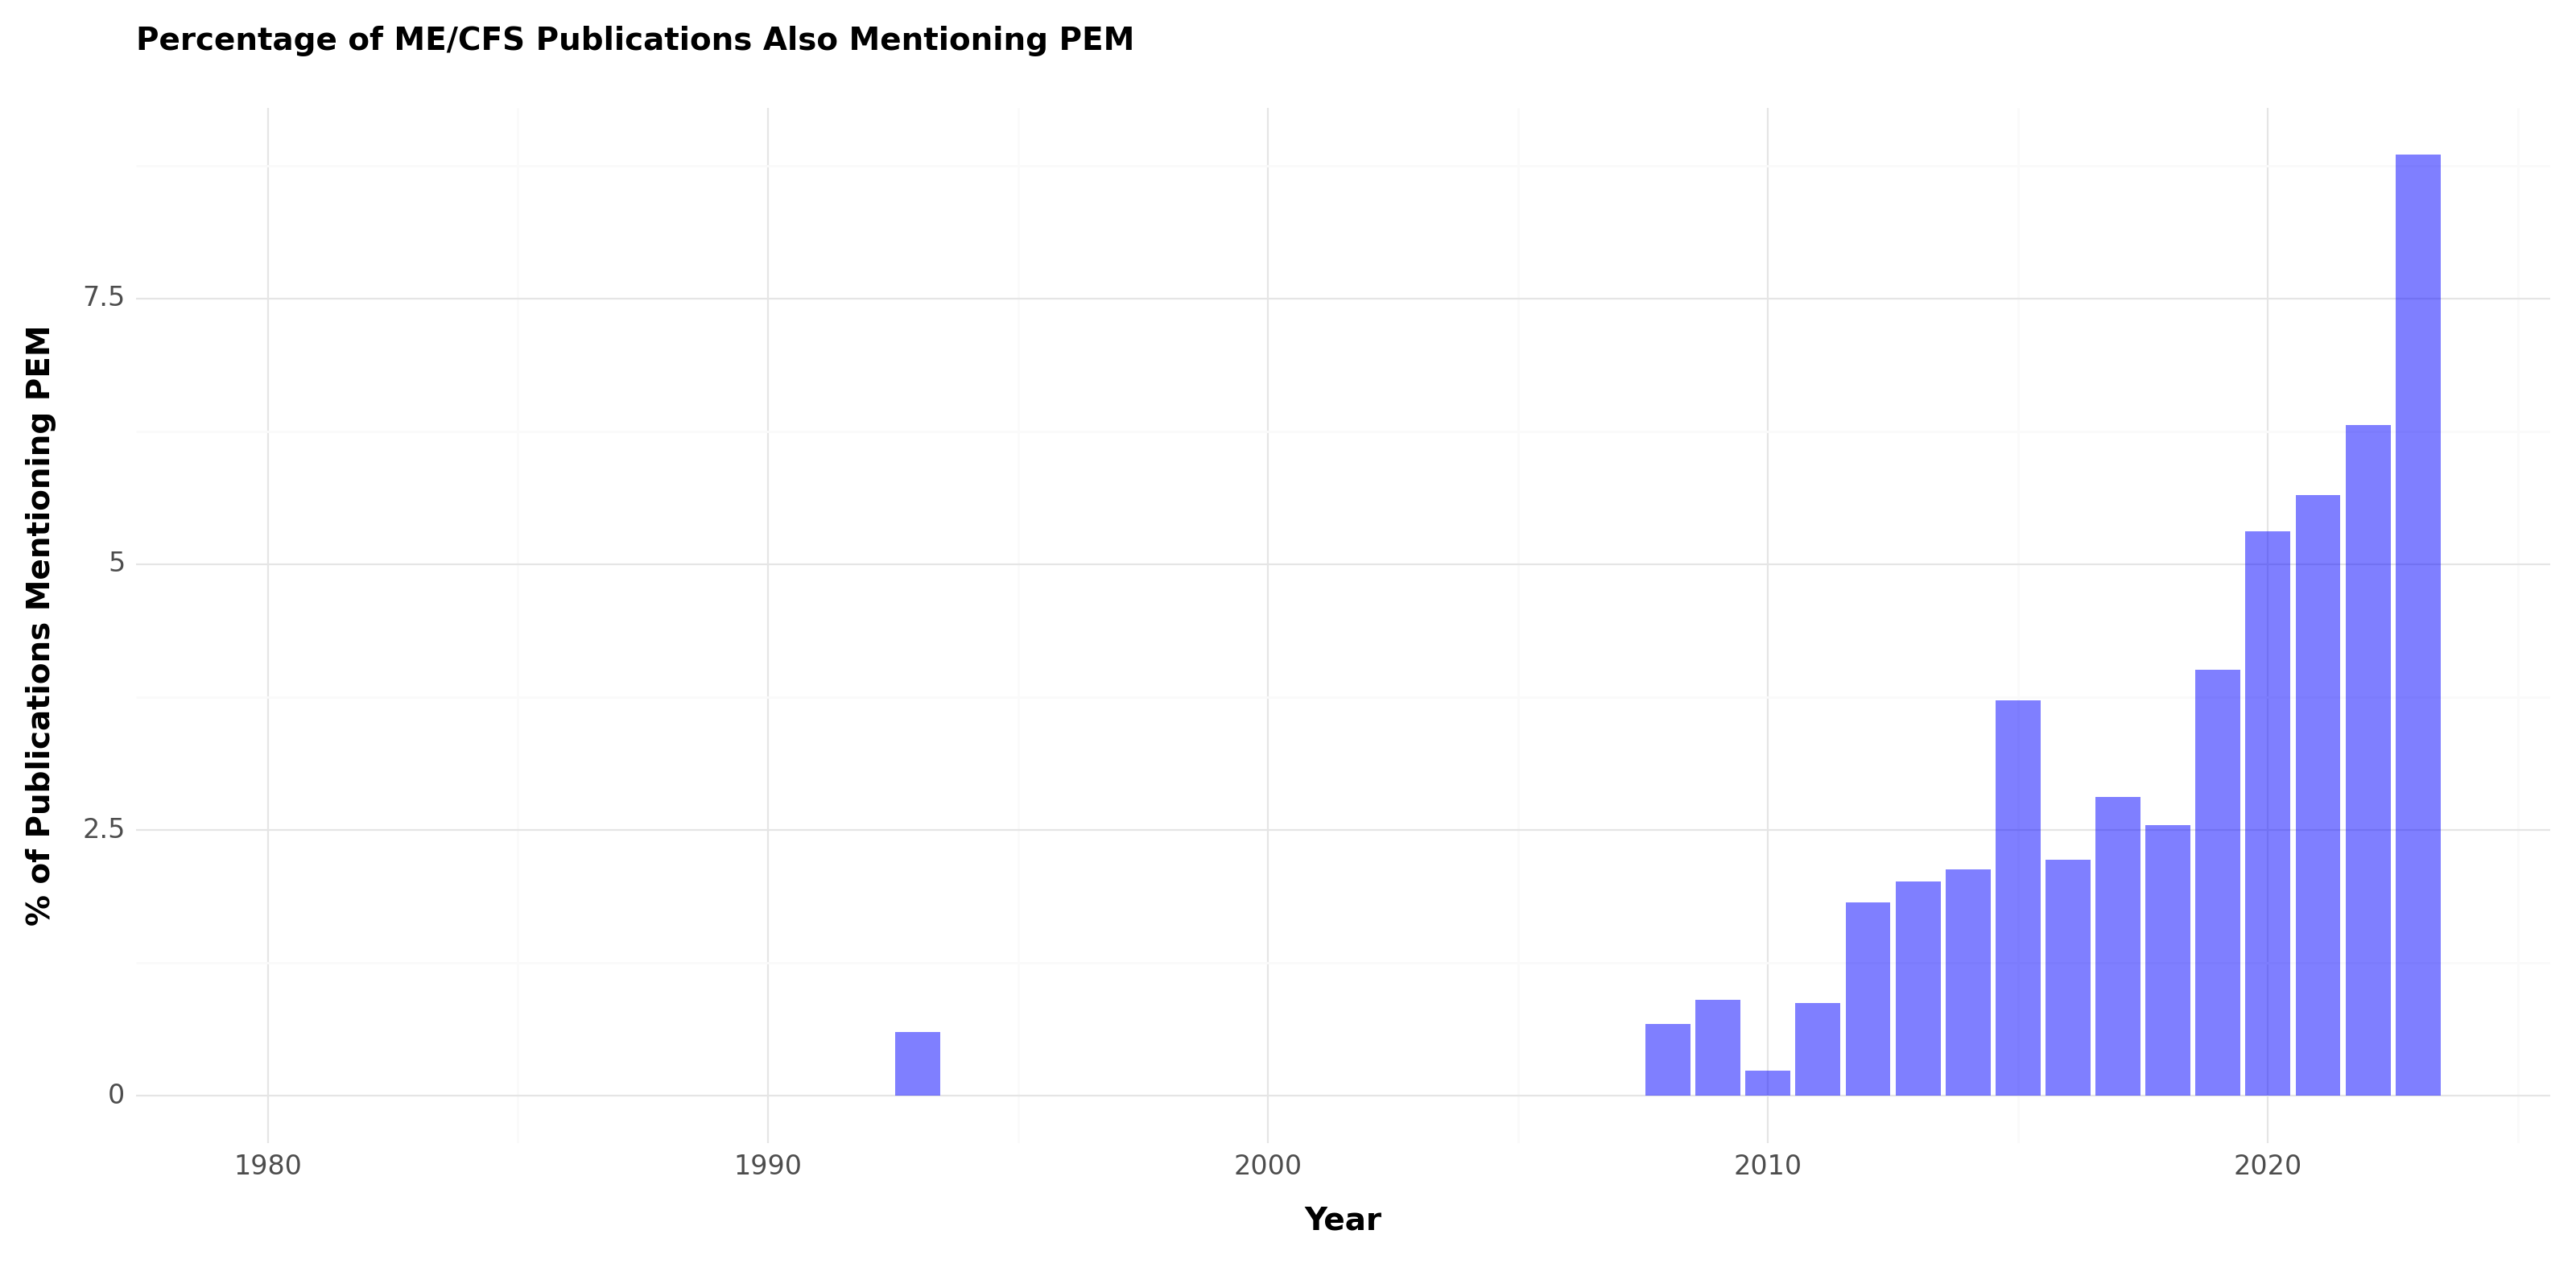

In [ ]:
# Create plot
plot = (
    ggplot(df_me, aes(x='Year', y='% Mentioning PEM'))
    + geom_bar(stat='identity', fill='blue', alpha=0.5)
    #+ geom_text(aes(label='% Mentioning PEM'), nudge_y=0.5)
    + labs(title='Percentage of ME/CFS Publications Also Mentioning PEM', x='Year', y='% of Publications Mentioning PEM')
    + theme_minimal()
    + theme(figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold'),
            axis_text=element_text(size=12),
            plot_title=element_text(size=14, weight='bold'),
            legend_text=element_text(size=16))
)

# Display the plot
print(plot)

#### 3.2 | % ME/CFS & LC Publications Mentioning PEM
---

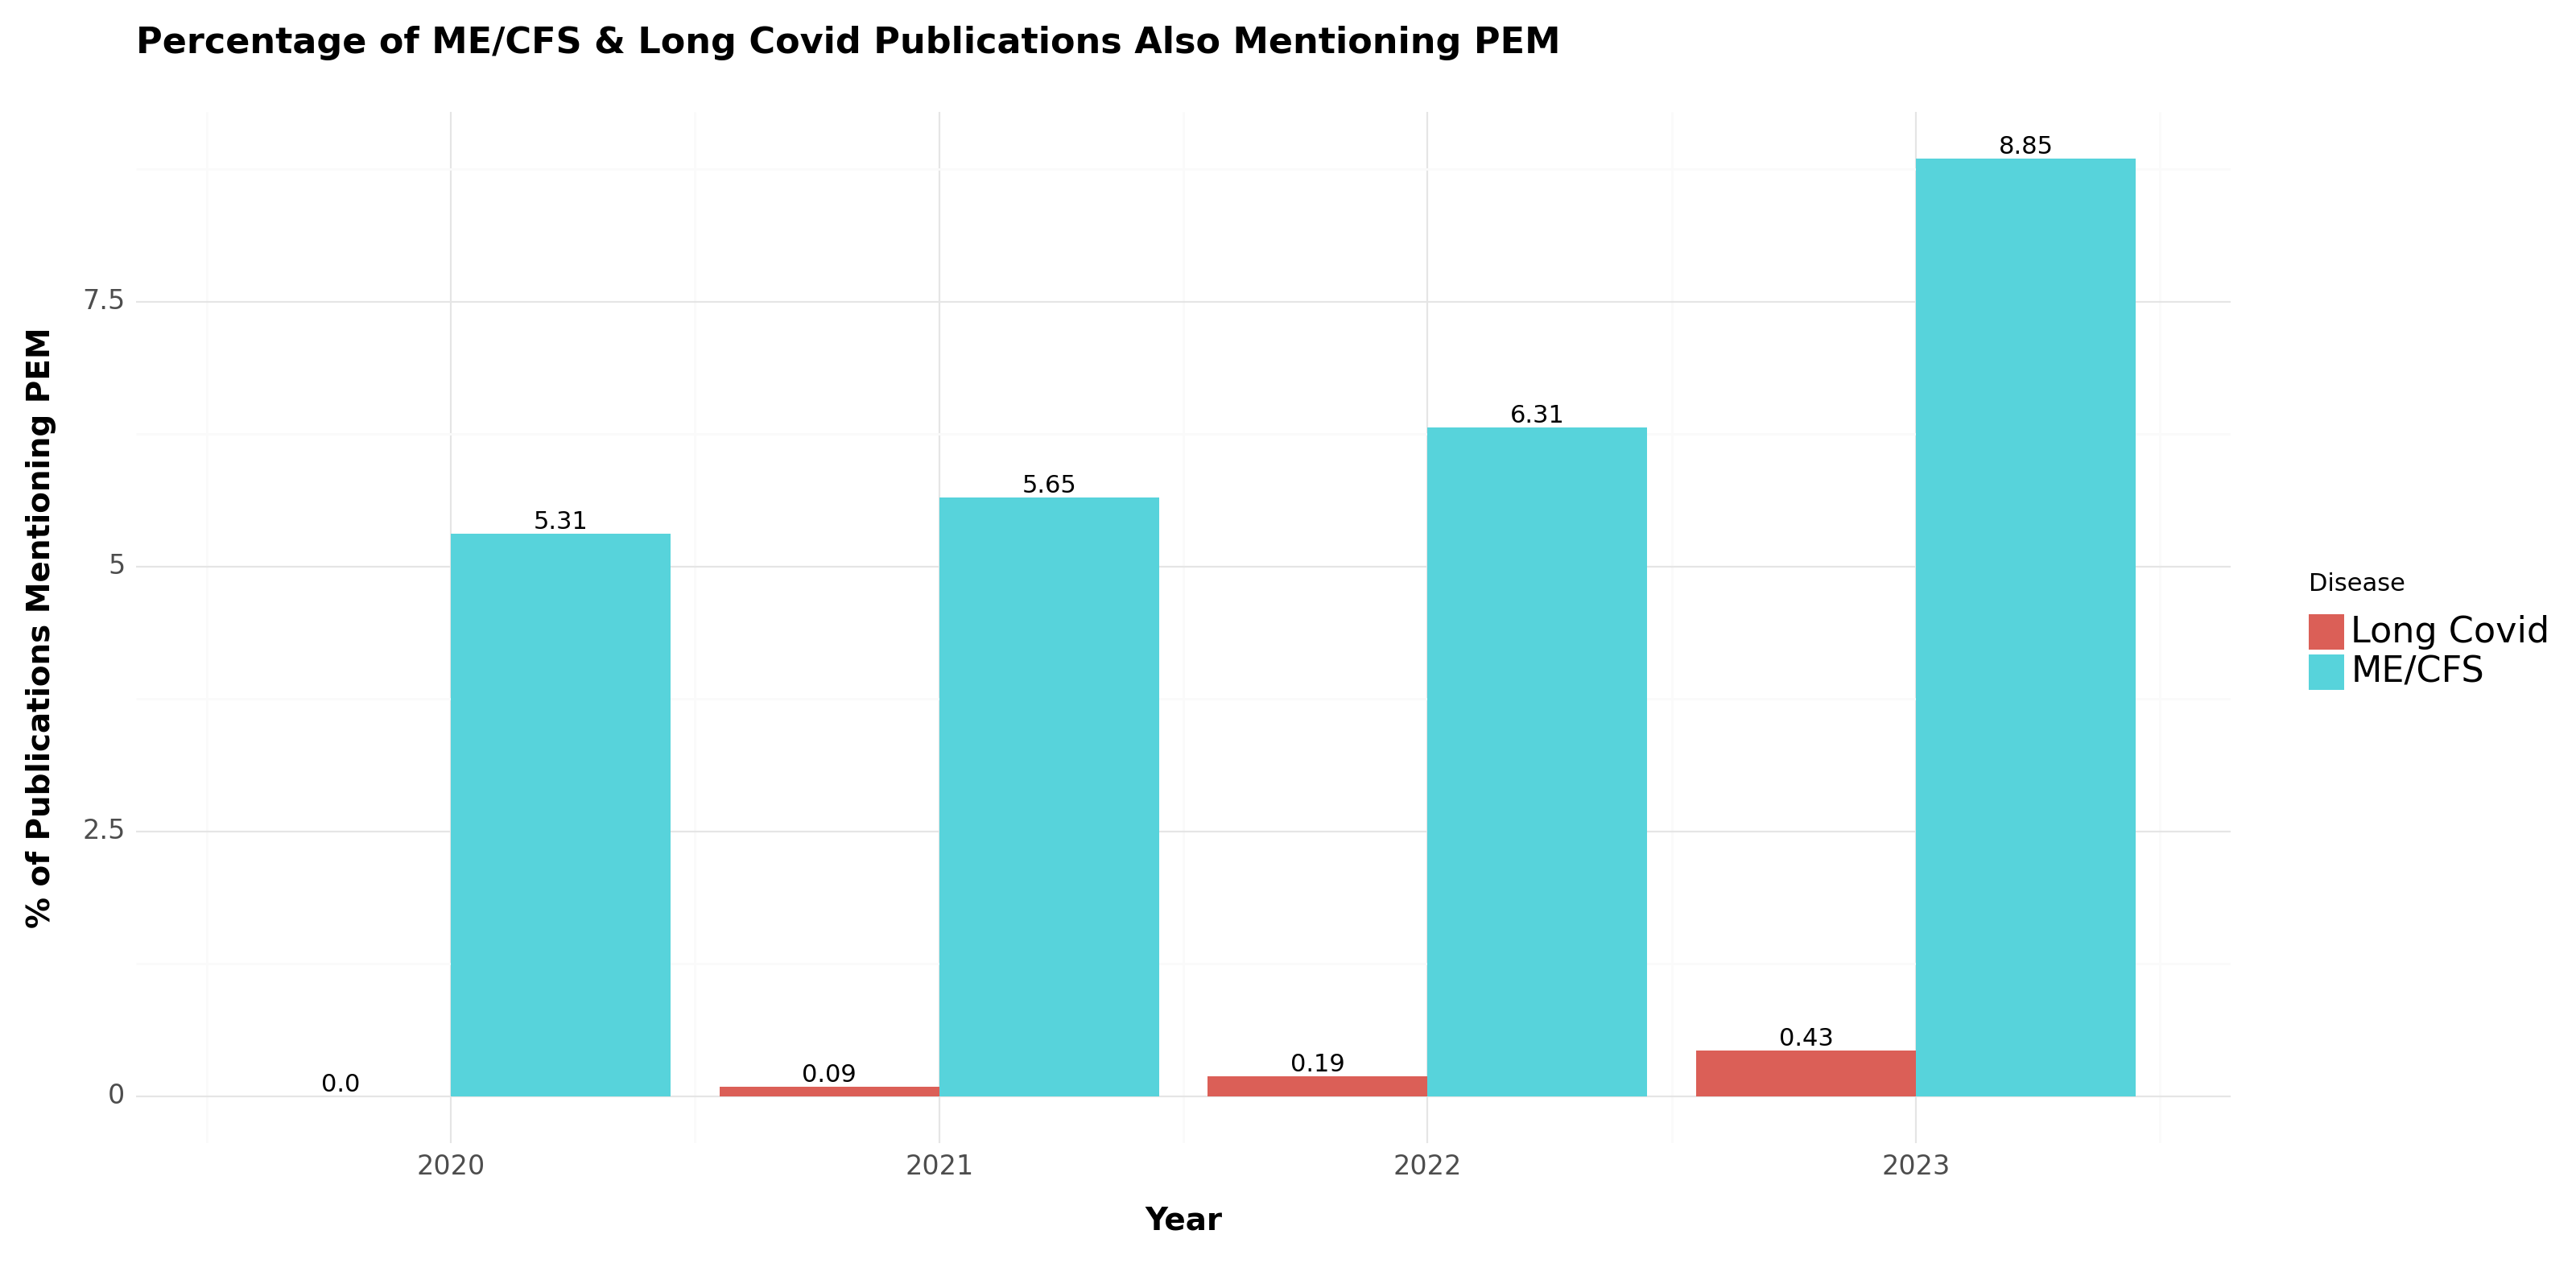

In [ ]:
# Create plot
plot = (
    ggplot(df_lc_vs_me, aes(x='Year', y='% Mentioning PEM', fill='Disease'))
    + geom_bar(stat='identity', position='dodge')
    + geom_text(aes(label='% Mentioning PEM'), position=position_dodge(width=0.9), va='bottom')
    + labs(title='Percentage of ME/CFS & Long Covid Publications Also Mentioning PEM',
           x='Year', y='% of Publications Mentioning PEM', fill='Disease')
    + theme_minimal()
    + theme(figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold'),
            axis_text=element_text(size=12),
            plot_title=element_text(size=16, weight='bold'),
            legend_text=element_text(size=16))
)

# Display the plot
print(plot)